In [1]:
import spacy
import numpy as np
from keras.preprocessing import sequence
import pandas as pd
import matplotlib.pyplot as plt
import h5py

Using TensorFlow backend.


In [2]:
RECORDS = None  # None means 'load all'
COLUMN = 'Text'
MAX_WORDS_IN_SENTENCE = 200

In [3]:
nlp = spacy.load('en_vectors_web_lg')

In [4]:
import sqlite3
import re

def clear_text(text):
    only_alpha_regex = re.compile(r'[^\w+ ]')
    return only_alpha_regex.sub('', text)


def get_query(count, text_column):
    query = """
    SELECT Score, lower({}) as Text
    FROM Reviews
    WHERE Score != 3
    """.format(text_column)
    if count is not None:
        query += " LIMIT {}".format(count)
    return query


def describe_data(messages):
    from IPython.display import display
    display("First 10 rows")
    display(messages.head(10))
    
    display("Words statistics")
    display(messages['Text'].apply(lambda x: len(x.split())).describe())


def load_data(count=None, text_column='Text'):
    connection = sqlite3.connect('../data/database.sqlite')
    query = get_query(count, text_column)
    messages = pd.read_sql_query(query, connection)

    messages['Label'] = messages.apply(lambda x: int(x['Score'] > 3), axis=1)
    messages['Text'] = messages['Text'].apply(clear_text)
    describe_data(messages)
    return messages


In [5]:
import os

from sklearn.cross_validation import train_test_split


def text_to_tokens(text):
    processed_text = nlp(text)
    tokens = [w.lex_id for w in processed_text if (w.is_stop is False and str(w).isalnum())]
    return tokens


def get_cache_filename(prefix, **kwargs):
    params = [str(kwargs[k]) for k in sorted(kwargs.keys()) if kwargs[k]]
    return "{}_{}.h5".format(prefix, '_'.join(params))


def preprocess_and_save_to_file(records, labels, filename):
    tokens = records.apply(text_to_tokens)
    tokens.to_hdf(filename, 'tokens', mode='w')
    labels.to_hdf(filename, 'labels', mode='a')
    return tokens, labels


def load_data_from_file(filepath):
    tokens = pd.read_hdf(filepath, 'tokens')
    labels = pd.read_hdf(filepath, 'labels')
    return tokens, labels


def get_data(count=None, column='Text'):
    filename = get_cache_filename('preprocessed_data', count=count, column=column)
    filepath = os.path.join('../data', filename)
    try:
        tokens, labels = load_data_from_file(filepath)
    except:
        messages = load_data(count, column)
        text = messages['Text']
        labels = messages['Label']
        tokens, labels = preprocess_and_save_to_file(text, labels, filepath)
    return tokens, labels

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
from itertools import cycle


def word_to_vector(nlp, word):
    try:
        return nlp.vocab.vectors.data[word]
    except IndexError:
        return None

def sentence_to_vectors(nlp, sentence):
    word_vectors = [word_to_vector(nlp, word) for word in sentence]
    return [word_vector for word_vector in word_vectors if isinstance(word_vector, np.ndarray)]

def get_batch_ids(ids, batch_size):
    n_batches = len(ids) // batch_size
    indices = [
        slice(i * batch_size, (i + 1) * batch_size)
        for i in range(n_batches)
    ]
    if len(ids) % batch_size:  # if list cannot be split equally, the remainder is yielded
        indices += [slice(n_batches * batch_size, len(ids))]
    return indices

def process_single_batch(tokens, max_len):
    word_vectors = [sentence_to_vectors(nlp, sentence) for sentence in tokens]
    word_vectors = sequence.pad_sequences(word_vectors, maxlen=max_len, dtype='float32')
    return word_vectors

def get_data_generator(nlp, inputs, labels, batch_size, max_len):
    indices = get_batch_ids(range(len(inputs)), batch_size)
    n_batches = len(indices)
    
    def batch_generator():
        for batch_indices in cycle(indices):
            batch_inputs = inputs[batch_indices]
            batch_labels = labels[batch_indices]
            word_vectors = process_single_batch(batch_inputs, max_len)
            yield word_vectors, np.array(batch_labels)
            
    return n_batches, batch_generator()

In [7]:
X, y = get_data(count=RECORDS, column=COLUMN)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

n_train_batches, train_generator = get_data_generator(
    nlp, X_train, y_train, batch_size=128, max_len=MAX_WORDS_IN_SENTENCE)
n_test_batches, test_generator = get_data_generator(
    nlp, X_test, y_test, batch_size=128, max_len=MAX_WORDS_IN_SENTENCE)

In [8]:
from keras.layers import Dense, Conv1D, BatchNormalization, GlobalMaxPooling1D, \
    Activation, Dropout, MaxPooling1D, Input, concatenate
from keras.models import Sequential 
from keras.regularizers import l2

def build_conv1d(max_len=MAX_WORDS_IN_SENTENCE, embedding_dim=300, filters=32, kernel_size=5, l2_weight=0.001,
                 dropout_rate=0.7):
    model = Sequential([
        Conv1D(
            filters, kernel_size, strides=1, kernel_regularizer=l2(l2_weight),
            input_shape=(max_len, embedding_dim), padding='valid', activation='relu'),
        MaxPooling1D(5),
        BatchNormalization(),
        Conv1D(
            2 * filters, kernel_size, strides=1, kernel_regularizer=l2(l2_weight),
            input_shape=(max_len, embedding_dim), padding='valid', activation='relu'),
        GlobalMaxPooling1D(),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, kernel_regularizer=l2(l2_weight)),
    ])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
model = build_conv1d()

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 196, 32)           48032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 32)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 39, 32)            128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 64)            10304     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [11]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=n_train_batches,
    epochs=5,
    verbose=1,
    validation_data=test_generator,
    validation_steps=n_test_batches)

Epoch 1/5
3081/3081 [==============================] - 130s 42ms/step - loss: 0.5070 - acc: 0.7665 - val_loss: 0.1518 - val_acc: 0.8888
Epoch 2/5
3081/3081 [==============================] - 134s 43ms/step - loss: 0.1239 - acc: 0.8915 - val_loss: 0.0904 - val_acc: 0.9083
Epoch 3/5
3081/3081 [==============================] - 130s 42ms/step - loss: 0.0911 - acc: 0.8993 - val_loss: 0.0851 - val_acc: 0.9087
Epoch 4/5
3081/3081 [==============================] - 132s 43ms/step - loss: 0.0899 - acc: 0.8993 - val_loss: 0.0844 - val_acc: 0.9068
Epoch 5/5
3081/3081 [==============================] - 129s 42ms/step - loss: 0.0886 - acc: 0.8990 - val_loss: 0.0833 - val_acc: 0.9071


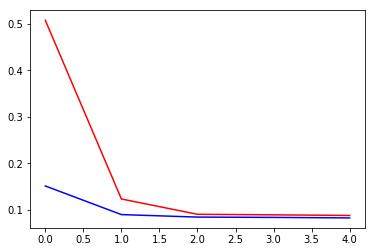

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], c='red')
_ = plt.plot(history.history['val_loss'], c='blue')

In [14]:
filename = get_cache_filename('model', records=RECORDS, column=COLUMN, max_words=MAX_WORDS_IN_SENTENCE)
filepath = os.path.join('../models', filename)
model.save(filepath)